In [34]:
import data_analysis.data as data
import pandas as pd
import pulp
import itertools
import numpy as np



# set depot latitude and longitude (just took coordinates for Leith)
depot_latitude = 55.972941
depot_longitude = -3.157436


# get names of all existing stations
october_data = data.load_data('10.csv')
october_data = october_data.drop(index=[5806,5853])
unique_stations = october_data.start_station_name.unique()

In [35]:

#create empty dataframe
df_loc = pd.DataFrame(columns = ['station_name', 'latitude', 'longitude'])

# extract coordinates for each station
for station in unique_stations:
    lat = (october_data[october_data['start_station_name'] == station].iloc[0,6])
    long = (october_data[october_data['start_station_name'] == station].iloc[0,7])
    new_row = {'station_name': station, 'latitude': lat, 'longitude': long}
    #append row to the dataframe
    df_loc = df_loc.append(new_row, ignore_index=True)



In [36]:
# add a for each station for the planning period
demand = [5] * len(unique_stations)
df_loc['demand'] = demand

# add depot to top of the dataframe
depot = pd.DataFrame ({'station_name': 'depot', 'latitude': depot_latitude, 'longitude': depot_longitude, 'demand': 0}, index=[0])
df_loc = pd.concat([depot, df_loc]).reset_index(drop=True)

    
df_loc


,station_name,latitude,longitude,demand
0,depot,55.972941,-3.157436,0
1,EICC,55.946071,-3.210396,5
2,Morningside Road,55.927985,-3.209750,5
3,St Andrews House,55.953164,-3.181682,5
4,Haymarket Station,55.945569,-3.218185,5
...,...,...,...,...
106,Borrowman Square,55.982606,-3.381455,5
107,Tesco Ferrymuir,55.983766,-3.401352,5
108,Picardy Place,55.956535,-3.186248,5
109,Scotstoun House,55.981107,-3.394211,5


In [37]:
# preselection mechanisms:
# 1) 

df_loc = df_loc.head(15)
df_loc.demand[3] = -15
df_loc.demand[8] = -10
df_loc.demand[5] = -5
df_loc.demand[12] = -10

df_loc

<ipython-input-37-cf2b7945b5e2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loc.demand[3] = -15
C:\Users\Nikolas\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3343: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
<ipython-input-37-cf2b7945b5e2>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loc.demand[8] = -10
<ipython-input-37-cf2b7945b5e2>:7: SettingWithCopyW

,station_name,latitude,longitude,demand
0,depot,55.972941,-3.157436,0
1,EICC,55.946071,-3.210396,5
2,Morningside Road,55.927985,-3.209750,5
3,St Andrews House,55.953164,-3.181682,-15
4,Haymarket Station,55.945569,-3.218185,5
5,Abbeyhill,55.955248,-3.172216,-5
6,Dynamic Earth,55.951089,-3.175725,5
7,Meadow Place,55.940238,-3.194640,5
8,Royal Edinburgh Hospital,55.927818,-3.213308,-10
9,Boroughmuir,55.940071,-3.215336,5


In [38]:

df_dist = pd.DataFrame(columns = ['station_1', 'station_2', 'distance'])
# calculate distances
for station_1 in df_loc['station_name']:
    for station_2 in df_loc['station_name']:
        lat_1 = df_loc[df_loc['station_name'] == station_1].iloc[0,1]
        long_1 = df_loc[df_loc['station_name'] == station_1].iloc[0,2]
        
        lat_2 = df_loc[df_loc['station_name'] == station_2].iloc[0,1]
        long_2 = df_loc[df_loc['station_name'] == station_2].iloc[0,2]
        
        dist = data.compute_distance(lat_1, long_1, lat_2, long_2)
        
        new_row = {'station_1': station_1, 'station_2': station_2, 'distance': dist}
        #append row to the dataframe
        df_dist = df_dist.append(new_row, ignore_index=True)

print(df_dist)
# calculate distance matrix

num_of_stations = len(df_dist['station_1'].unique())
print(num_of_stations)

dist_matrix = np.zeros((num_of_stations,num_of_stations))
for i in range(num_of_stations):
    for j in range(num_of_stations):
        dist_matrix[i][j] = df_dist.iloc[i*num_of_stations + j, 2]

dist_matrix

       station_1           station_2  distance
0          depot               depot  0.000000
1          depot                EICC  4.450458
2          depot    Morningside Road  5.968153
3          depot    St Andrews House  2.667888
4          depot   Haymarket Station  4.855551
..           ...                 ...       ...
220  Duke Street       Hunter Square  2.486156
221  Duke Street     Scotland Street  1.994215
222  Duke Street          Leith Walk  0.727842
223  Duke Street  South Trinity Road  2.538368
224  Duke Street         Duke Street  0.000000

[225 rows x 3 columns]
15


array([[0.        , 4.4504581 , 5.96815317, 2.66788846, 4.85555123,
        2.17249779, 2.68403808, 4.31265347, 6.10722445, 5.1347332 ,
        3.19366842, 2.74923787, 1.486047  , 3.15015638, 0.75847272],
       [4.4504581 , 0.        , 2.01201765, 1.9546422 , 0.48829771,
        2.587644  , 2.23040542, 1.17651538, 2.03829759, 0.73479855,
        1.46744352, 1.84314621, 2.97627735, 2.81317236, 3.69876335],
       [5.96815317, 2.01201765, 0.        , 3.30162567, 2.02524171,
        3.82910709, 3.3312285 , 1.65635453, 0.22249196, 1.38865914,
        2.7851309 , 3.71137646, 4.60740589, 4.821989  , 5.27095102],
       [2.66788846, 1.9546422 , 3.30162567, 0.        , 2.42526442,
        0.63339731, 0.43694519, 1.64886089, 3.4393955 , 2.55235254,
        0.53400024, 1.17525917, 1.3570407 , 2.59960723, 1.97444338],
       [4.85555123, 0.48829771, 2.02524171, 2.42526442, 0.        ,
        3.05856975, 2.71484263, 1.58197453, 1.9977146 , 0.63676655,
        1.95031347, 2.17131932, 3.37163579, 

In [39]:
# Parameter initialisation

# the number of vehicles
vehicle_count = 1

# number of stations
station_count = len(df_dist['station_1'].unique())
print(station_count)

# vehicle capacity
vehicle_capacity = 15

15


In [40]:
# set up an optimisation model with pulp

for vehicle_count in range(1,vehicle_count+1):
    
    # definition of LpProblem instance
    problem = pulp.LpProblem("bike_reallocation", pulp.LpMinimize)

    # definition of decision variables: x(1,j,k) 1 if vehicle k drives from i to j
    # exclude variables for driving to same station (unnecessary)
    x = [[[pulp.LpVariable("x%s_%s,%s"%(i,j,k), cat="Binary") if i != j else None for k in range(vehicle_count)]for j in range(station_count)] for i in range(station_count)]
    # flow of bikes variables: how many bikes are transported from i to j
    f = [[pulp.LpVariable("f%s_%s"%(i,j), cat="Continuous", lowBound = 0) if i != j else None for j in range(station_count)] for i in range(station_count)]
    # for subtour elimination
    u = [[pulp.LpVariable("u%s_%s"%(i,k), cat="Continuous", lowBound = 0) for k in range(vehicle_count)] for i in range(station_count)]
    
    
    # objective function: distance as a first measure of cost
    problem += pulp.lpSum(dist_matrix[i][j] * x[i][j][k] + f[i][j] if i != j else 0
                          for k in range(vehicle_count) 
                          for j in range(station_count) 
                          for i in range(station_count))

    # constraints
    # only one visit per vehicle per bike station
    for j in range(1, station_count):
        problem += pulp.lpSum(x[i][j][k] if i != j else 0 
                              for i in range(station_count) 
                              for k in range(vehicle_count)) == 1 

    # exactly one departure and one arrival from depot/back to depot per vehicle 
    for k in range(vehicle_count):
        problem += pulp.lpSum(x[0][j][k] for j in range(1,station_count)) == 1
        problem += pulp.lpSum(x[i][0][k] for i in range(1,station_count)) == 1

    # flow constraint: if vehicle drives to node it also has to leave it
    for k in range(vehicle_count):
        for j in range(station_count):
            problem += pulp.lpSum(x[i][j][k] if i != j else 0 
                                  for i in range(station_count)) -  pulp.lpSum(x[j][i][k] for i in range(station_count)) == 0

    
    
    # flow of bikes varies according to demand at every node
    # negative demand implies that bikes have to be picked up
    for i in range(1, station_count):
        problem += pulp.lpSum(f[j][i] for j in range(station_count)) - pulp.lpSum(f[i][j] for j in range(station_count)) == df_loc.demand[i]
    
    # flow of bikes between two stations cannot exceed vehicle capacity
    for i in range(station_count):
        for j in range(station_count):
            problem += f[i][j] <= vehicle_capacity * pulp.lpSum(x[i][j][k] if i != j else 0 for k in range(vehicle_count))
    
    # flow of bikes between two stations cannot be negative
    for i in range(station_count):
        for j in range(station_count):
            if i != j:
                problem += f[i][j] >= 0
                
    # MTZ formulation
    for k in range(vehicle_count):
        for i in range(1,station_count):
            for j in range(1,station_count):
                if i != j:
                    problem += u[i][k] - u[j][k] + (station_count) * x[i][j][k] <= station_count - 1
                

    for i in range(1,station_count):
        problem += u[i][k] <= station_count - 1 
        problem += u[i][k] >= 1
    
    # constraint for the removal of subtours
    #subtours = []
    #for i in range(2,station_count):
     #    subtours += itertools.combinations(range(1,station_count), i)

   # for s in subtours:
      #  problem += pulp.lpSum(x[i][j][k] if i !=j else 0 for i, j in itertools.permutations(s,2) for k in range(vehicle_count)) <= len(s) - 1

    
    # print vehicle_count which is needed for solving the problem
    # print calculated minimum distance value
    if problem.solve() == 1:
        print('Vehicle Requirements:', vehicle_count)
        print('cost approx:', pulp.value(problem.objective))
        for i in range(station_count):
            for j in range(station_count):
                for k in range(vehicle_count):
                    if i!=j and pulp.value(x[i][j][k]) != 0:
                        print(f'bikes transported from {df_loc.station_name[i]} to {df_loc.station_name[j]}', pulp.value(f[i][j]))
                        
        break
    else:
        print('not solved to optimality')
        
   

Vehicle Requirements: 1
cost approx: 99.54885849111186
bikes transported from depot to South Trinity Road 10.0
bikes transported from EICC to Haymarket Station 10.0
bikes transported from Morningside Road to Meadow Place 5.0
bikes transported from St Andrews House to EICC 15.0
bikes transported from Haymarket Station to Boroughmuir 5.0
bikes transported from Abbeyhill to Duke Street 5.0
bikes transported from Dynamic Earth to Hunter Square 5.0
bikes transported from Meadow Place to Abbeyhill 0.0
bikes transported from Royal Edinburgh Hospital to Morningside Road 10.0
bikes transported from Boroughmuir to Royal Edinburgh Hospital 0.0
bikes transported from Hunter Square to St Andrews House 0.0
bikes transported from Scotland Street to Leith Walk 0.0
bikes transported from Leith Walk to Dynamic Earth 10.0
bikes transported from South Trinity Road to Scotland Street 5.0
bikes transported from Duke Street to depot 0.0


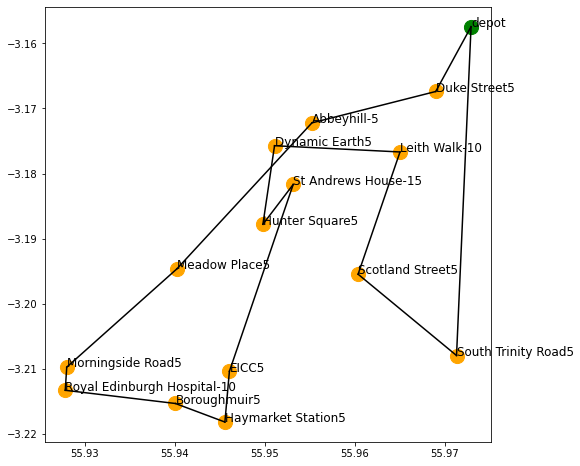

In [41]:
# visualization : plotting with matplolib
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
for i in range(station_count):    
    if i == 0:
        plt.scatter(df_loc.latitude[i], df_loc.longitude[i], c='green', s=200)
        plt.text(df_loc.latitude[i], df_loc.longitude[i], "depot", fontsize=12)
    else:
        plt.scatter(df_loc.latitude[i], df_loc.longitude[i], c='orange', s=200)
        plt.text(df_loc.latitude[i], df_loc.longitude[i], str(df_loc.station_name[i]) + str(df_loc.demand[i]), fontsize=12)

for k in range(vehicle_count):
    for i in range(station_count):
        for j in range(station_count):
            if i != j and pulp.value(x[i][j][k]) == 1:
                plt.plot([df_loc.latitude[i], df_loc.latitude[j]], [df_loc.longitude[i], df_loc.longitude[j]], c="black")

plt.show()